## Importar las bibliotecas necesarias

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import seaborn as sns
from scipy import stats
import warnings

In [193]:
warnings.filterwarnings("ignore")

## Carga y preparación de datos

In [194]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")

df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'ds', 'BTCUSDT': 'y'})
df_selected = df_selected.dropna()

df_selected["unique_id"] = "1"
df_selected.columns = ["ds", "y", "unique_id"]

df_selected["ds"] = pd.to_datetime(df_selected["ds"])

## Análisis de autocorrelación y descomposición estacional

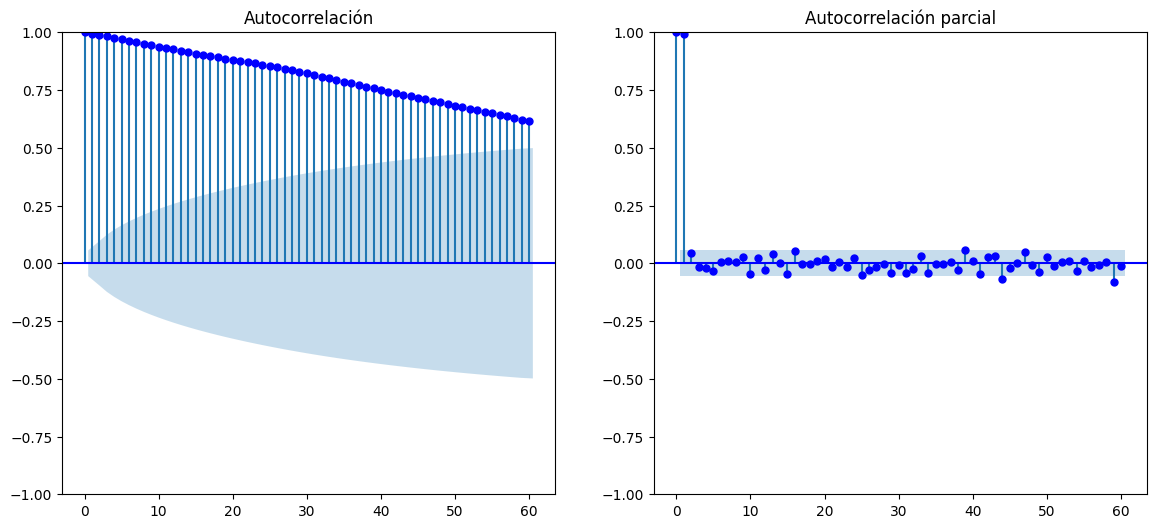

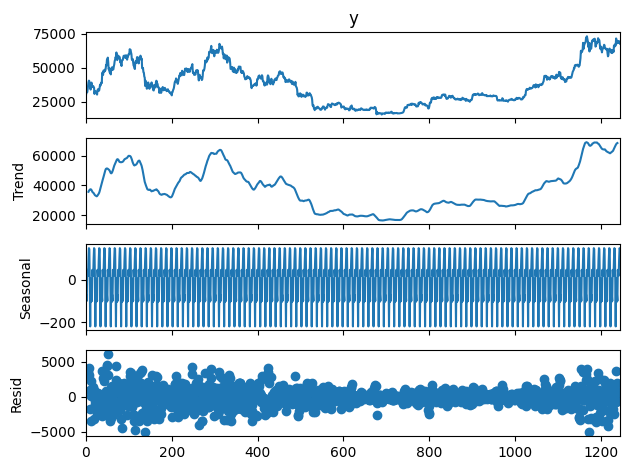

In [195]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelación")
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Autocorrelación parcial')

decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

## Separación de los datos en conjuntos de entrenamiento y prueba

In [196]:
Y_train_df = df_selected[df_selected.ds <= '2024-05-01']
Y_test_df = df_selected[df_selected.ds > '2024-05-01']

## Configuración y ajuste del modelo AutoARIMA

In [197]:
season_length = 12
horizon = len(Y_test_df)
models = [AutoARIMA(season_length=season_length)]

sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D',
                   n_jobs=-1)

sf.fit()

StatsForecast(models=[AutoARIMA])

## Análisis del modelo ajustado y sus residuos

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 2, 0, 12, 1, 0)


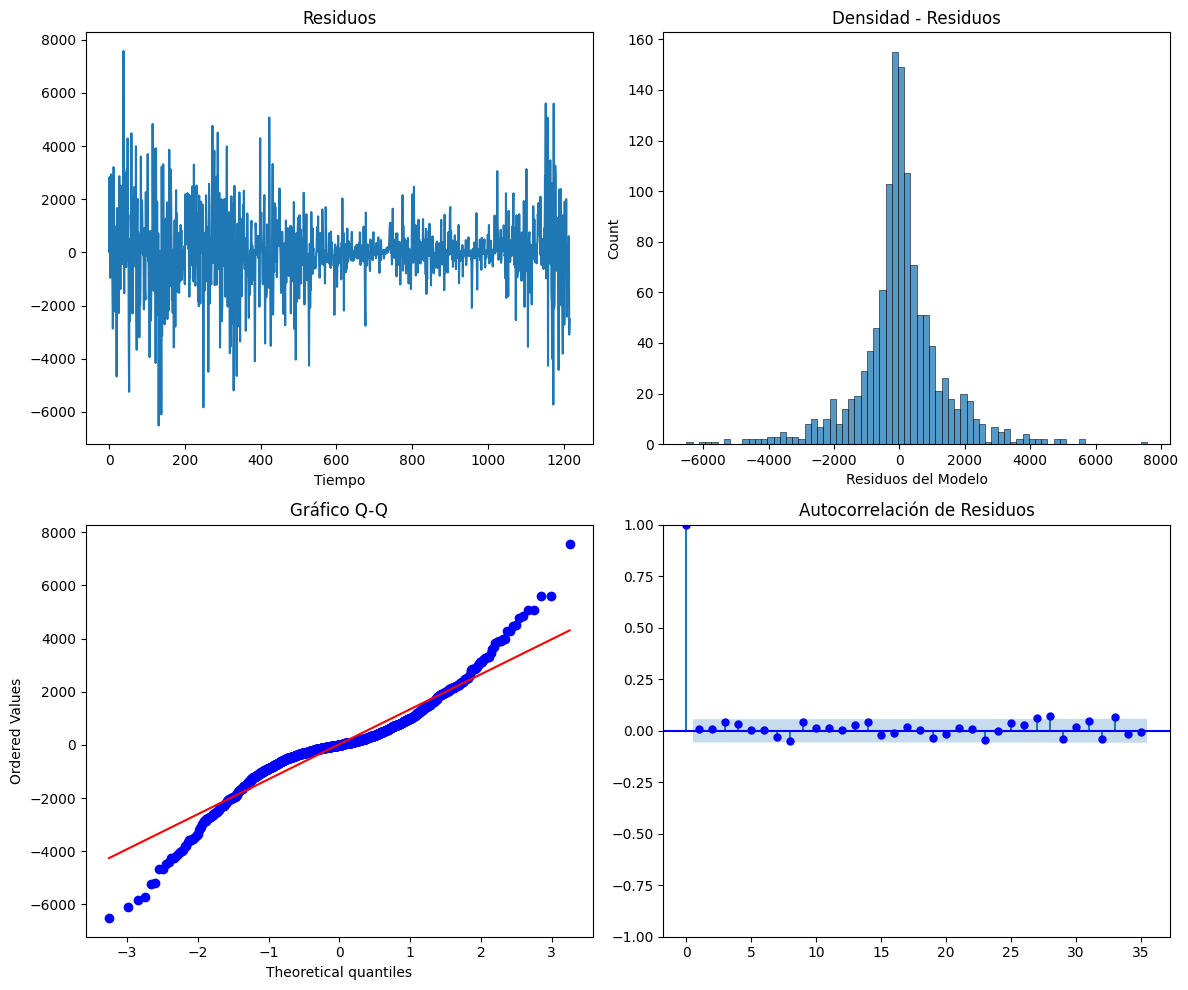

In [198]:
result = sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

residual = pd.DataFrame(result.get("residuals"), columns=["Residuos del Modelo"])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
residual['Residuos del Modelo'].plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuos")
axs[0, 0].set_xlabel('Tiempo')

sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
axs[0, 1].set_title("Densidad - Residuos")

stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Gráfico Q-Q')

plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
axs[1, 1].set_title("Autocorrelación de Residuos")
plt.tight_layout()
plt.show()

## Generación y visualización de previsiones

In [199]:
horizon = 48
levels = [99] 

forecast_df = sf.forecast(h=28, level = levels, fitted = True)
forecast_df = forecast_df.reset_index()
forecast_df.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,1,2024-05-02,58590.480469,55059.085938,62121.875000
1,1,2024-05-03,58429.542969,53596.304688,63262.777344
2,1,2024-05-04,58413.492188,52552.605469,64274.378906
3,1,2024-05-05,58398.480469,51665.488281,65131.476562
4,1,2024-05-06,58343.546875,50839.093750,65848.007812


In [200]:
StatsForecast.plot(df_selected, forecast_df, plot_random = False)

In [201]:
print(forecast_df.tail())

   unique_id         ds     AutoARIMA  AutoARIMA-lo-99  AutoARIMA-hi-99
23         1 2024-05-25  58141.457031     42320.562500     73962.359375
24         1 2024-05-26  58152.042969     41979.988281     74324.093750
25         1 2024-05-27  58141.695312     41628.964844     74654.421875
26         1 2024-05-28  58134.113281     41287.398438     74980.828125
27         1 2024-05-29  58134.562500     40960.371094     75308.750000


## Métricas de evaluación

In [202]:
Y_test_df = Y_test_df.set_index('ds')
forecast_df = forecast_df.set_index('ds')

y_true = Y_test_df['y'].values
y_pred = forecast_df['AutoARIMA'].values

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

MAPE: 10.44%
sMAPE: 11.14%


## Identificar anomalías

In [203]:
insample_forecasts = sf.forecast_fitted_values().reset_index()
insample_forecasts.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
0,1,2021-01-01,29331.689453,29302.357422,25770.962891,32833.753906
1,1,2021-01-02,32178.330078,29348.357422,25816.960938,32879.753906
2,1,2021-01-03,33000.050781,31995.519531,28464.123047,35526.914062
3,1,2021-01-04,31988.710938,32942.644531,29411.250000,36474.042969
4,1,2021-01-05,33949.531250,32062.025391,28530.630859,35593.421875


In [204]:
anomalies = insample_forecasts.loc[(insample_forecasts['y'] >= insample_forecasts['AutoARIMA-hi-99']) | (insample_forecasts['y'] <= insample_forecasts['AutoARIMA-lo-99'])]
anomalies.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-99,AutoARIMA-hi-99
20,1,2021-01-21,30850.130859,35512.796875,31981.400391,39044.191406
38,1,2021-02-08,46374.871094,38801.132812,35269.738281,42332.527344
49,1,2021-02-19,55906.000000,51621.781250,48090.386719,55153.175781
53,1,2021-02-23,48891.000000,54134.925781,50603.527344,57666.320312
59,1,2021-03-01,49587.031250,45103.945312,41572.550781,48635.339844


In [205]:
StatsForecast.plot(insample_forecasts, plot_random = False, plot_anomalies = True)
